Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 2.1605, Val Loss: 1.7773, Val Acc: 31.39%
Epoch 2/20, Train Loss: 1.6640, Val Loss: 1.7013, Val Acc: 38.29%
Epoch 3/20, Train Loss: 1.4097, Val Loss: 1.2623, Val Acc: 53.73%
Epoch 4/20, Train Loss: 1.1868, Val Loss: 1.2121, Val Acc: 56.75%
Epoch 5/20, Train Loss: 1.0046, Val Loss: 1.0492, Val Acc: 63.49%
Epoch 6/20, Train Loss: 0.8649, Val Loss: 1.0900, Val Acc: 62.45%
Epoch 7/20, Train Loss: 0.7455, Val Loss: 0.7627, Val Acc: 73.61%
Epoch 8/20, Train Loss: 0.6536, Val Loss: 0.8950, Val Acc: 70.71%
Epoch 9/20, Train Loss: 0.5994, Val Loss: 0.8158, Val Acc: 72.46%
Epoch 10/20, Train Loss: 0.5662, Val Loss: 0.7279, Val Acc: 76.15%
Epoch 11/20, Train Loss: 0.5331, Val Loss: 0.8389, Val Acc: 72.02%
Epoch 12/20, Train Loss: 0.5142, Val Loss: 0.6612, Val Acc: 76.99%
Epoch 13/20, Train Loss: 0.4968, Val Loss: 0.7737, Val Acc: 74.26%
Epoch 14/20, Train Loss: 0.4758, Val Loss: 0.9221, Val Acc: 70

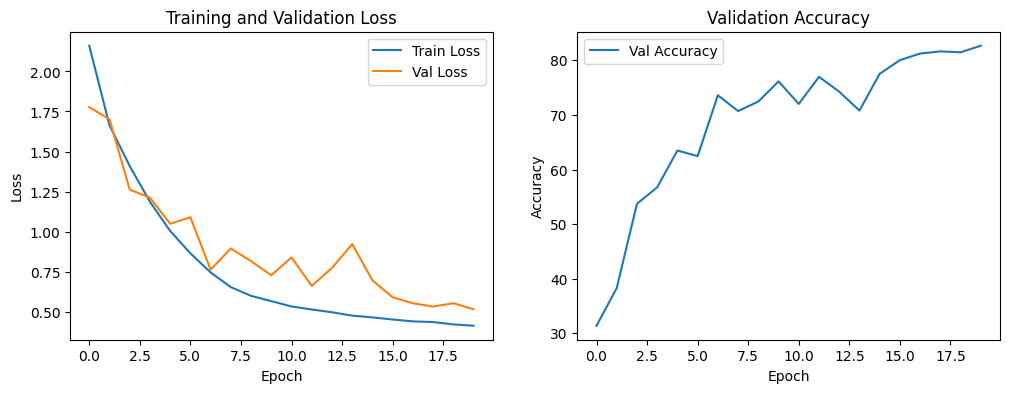

Total Trainable Parameters: 17075274


In [2]:
# ResNet 11 CIFAR 10 Dropout 0
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define ResNet-11 BasicBlock
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet-11 model
class ResNet11(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet11, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 11-layer ResNet Configuration
        self.layer1 = self._make_layer(64, 2, stride=1)  
        self.layer2 = self._make_layer(128, 2, stride=2)  
        self.layer3 = self._make_layer(256, 3, stride=2)  
        self.layer4 = self._make_layer(512, 3, stride=2)  
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet11(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 2.2091, Val Loss: 1.7011, Val Acc: 35.31%
Epoch 2/20, Train Loss: 1.5956, Val Loss: 1.4507, Val Acc: 45.75%
Epoch 3/20, Train Loss: 1.3694, Val Loss: 1.3948, Val Acc: 50.54%
Epoch 4/20, Train Loss: 1.1528, Val Loss: 1.1069, Val Acc: 60.14%
Epoch 5/20, Train Loss: 0.9882, Val Loss: 1.0706, Val Acc: 63.14%
Epoch 6/20, Train Loss: 0.8617, Val Loss: 0.9529, Val Acc: 66.31%
Epoch 7/20, Train Loss: 0.7514, Val Loss: 0.9165, Val Acc: 68.42%
Epoch 8/20, Train Loss: 0.6619, Val Loss: 0.7800, Val Acc: 73.27%
Epoch 9/20, Train Loss: 0.6112, Val Loss: 0.8283, Val Acc: 71.84%
Epoch 10/20, Train Loss: 0.5769, Val Loss: 0.7051, Val Acc: 75.71%
Epoch 11/20, Train Loss: 0.5447, Val Loss: 0.6144, Val Acc: 79.06%
Epoch 12/20, Train Loss: 0.5211, Val Loss: 0.7187, Val Acc: 75.73%
Epoch 13/20, Train Loss: 0.5010, Val Loss: 0.5530, Val Acc: 80.65%
Epoch 14/20, Train Loss: 0.4886, Val Loss: 0.6325, Val Acc: 79

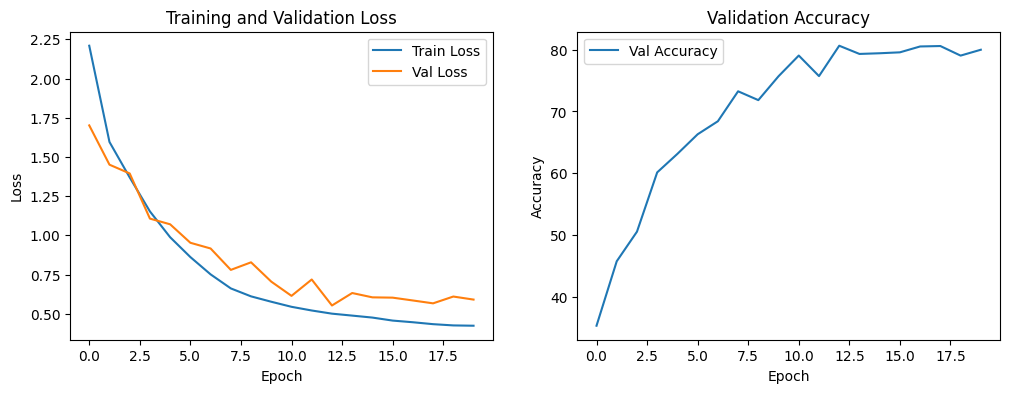

Model Size: 42.66 MB
Total Trainable Parameters: 11173962


In [6]:
# ResNet 18 CIFAR 10 Dropout 0
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BasicBlock.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Calculate model size
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return (param_size + buffer_size) / 1024**2  # Size in MB

model_size = get_model_size(model)
print(f"Model Size: {model_size:.2f} MB")

# Calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 4.1144, Val Loss: 3.7181, Val Acc: 11.58%
Epoch 2/20, Train Loss: 3.5213, Val Loss: 3.3531, Val Acc: 17.96%
Epoch 3/20, Train Loss: 3.1086, Val Loss: 2.9968, Val Acc: 25.30%
Epoch 4/20, Train Loss: 2.7500, Val Loss: 2.9213, Val Acc: 26.84%
Epoch 5/20, Train Loss: 2.3931, Val Loss: 2.4008, Val Acc: 36.60%
Epoch 6/20, Train Loss: 2.1439, Val Loss: 2.2095, Val Acc: 40.88%
Epoch 7/20, Train Loss: 1.9352, Val Loss: 2.0193, Val Acc: 45.68%
Epoch 8/20, Train Loss: 1.7916, Val Loss: 2.1995, Val Acc: 42.21%
Epoch 9/20, Train Loss: 1.6822, Val Loss: 2.0619, Val Acc: 44.89%
Epoch 10/20, Train Loss: 1.6060, Val Loss: 2.0381, Val Acc: 46.25%
Epoch 11/20, Train Loss: 1.5449, Val Loss: 1.8672, Val Acc: 48.63%
Epoch 12/20, Train Loss: 1.4853, Val Loss: 1.7397, Val Acc: 52.24%
Epoch 13/20, Train Loss: 1.4372, Val Loss: 1.7850, Val Acc: 51.29%
Epoch 14/20, Train Loss: 1.3929, Val Loss: 1.7856, Val Acc: 51

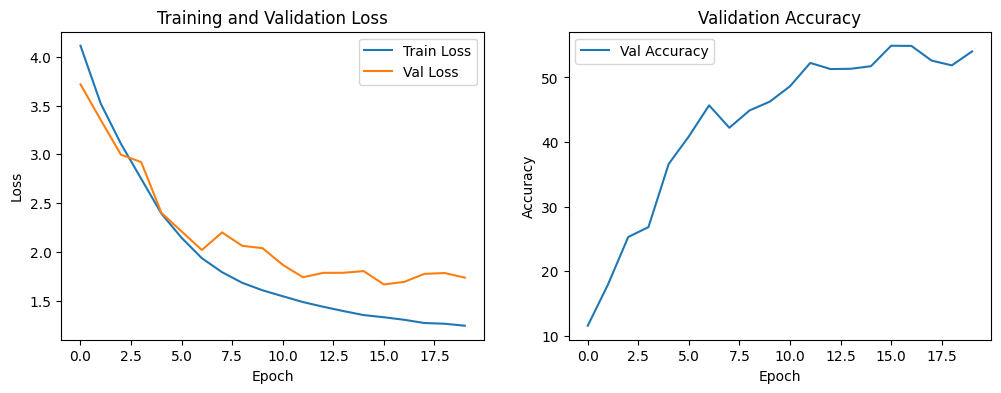

Total Trainable Parameters: 17121444


In [3]:
# ResNet 11 CIFAR 100 Dropout 0
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define ResNet-11 BasicBlock
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet-11 model
class ResNet11(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet11, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 11-layer ResNet Configuration
        self.layer1 = self._make_layer(64, 2, stride=1)  
        self.layer2 = self._make_layer(128, 2, stride=2)  
        self.layer3 = self._make_layer(256, 3, stride=2)  
        self.layer4 = self._make_layer(512, 3, stride=2)  
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 mean and std
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet11(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 4.0269, Val Loss: 3.7007, Val Acc: 11.97%
Epoch 2/20, Train Loss: 3.4379, Val Loss: 3.3162, Val Acc: 18.48%
Epoch 3/20, Train Loss: 2.9935, Val Loss: 2.9842, Val Acc: 25.38%
Epoch 4/20, Train Loss: 2.5709, Val Loss: 2.5486, Val Acc: 34.10%
Epoch 5/20, Train Loss: 2.2213, Val Loss: 2.3185, Val Acc: 37.81%
Epoch 6/20, Train Loss: 1.9769, Val Loss: 2.3438, Val Acc: 38.92%
Epoch 7/20, Train Loss: 1.8087, Val Loss: 1.9776, Val Acc: 46.27%
Epoch 8/20, Train Loss: 1.6897, Val Loss: 1.9946, Val Acc: 46.34%
Epoch 9/20, Train Loss: 1.6065, Val Loss: 1.8515, Val Acc: 49.69%
Epoch 10/20, Train Loss: 1.5339, Val Loss: 1.8428, Val Acc: 49.58%
Epoch 11/20, Train Loss: 1.4646, Val Loss: 2.1382, Val Acc: 45.60%
Epoch 12/20, Train Loss: 1.4416, Val Loss: 1.8423, Val Acc: 50.35%
Epoch 13/20, Train Loss: 1.3963, Val Loss: 2.0146, Val Acc: 47.66%
Epoch 14/20, Train Loss: 1.3518, Val Loss: 1.7311, Val Acc: 53

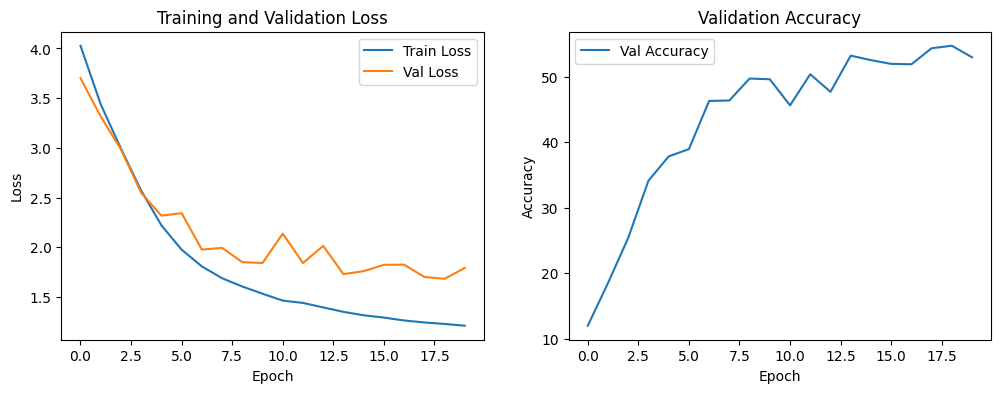

Total Trainable Parameters: 11220132


In [9]:
#  ResNet-18 CIFAR-100 Dropout =0
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define ResNet-18 BasicBlock
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet-18 Model (No Dropout)
class ResNet18(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 18-layer ResNet Configuration: [2,2,2,2]
        self.layer1 = self._make_layer(64, 2, stride=1)  
        self.layer2 = self._make_layer(128, 2, stride=2)  
        self.layer3 = self._make_layer(256, 2, stride=2)  
        self.layer4 = self._make_layer(512, 2, stride=2)  
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 mean and std
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 4.2923, Val Loss: 3.9001, Val Acc: 8.85%
Epoch 2/20, Train Loss: 3.7826, Val Loss: 3.6332, Val Acc: 12.68%
Epoch 3/20, Train Loss: 3.4751, Val Loss: 3.2210, Val Acc: 21.15%
Epoch 4/20, Train Loss: 3.2098, Val Loss: 3.0198, Val Acc: 24.56%
Epoch 5/20, Train Loss: 2.9735, Val Loss: 2.7175, Val Acc: 30.28%
Epoch 6/20, Train Loss: 2.7628, Val Loss: 2.5466, Val Acc: 33.76%
Epoch 7/20, Train Loss: 2.5678, Val Loss: 2.4474, Val Acc: 36.08%
Epoch 8/20, Train Loss: 2.4231, Val Loss: 2.4349, Val Acc: 35.82%
Epoch 9/20, Train Loss: 2.3064, Val Loss: 2.2366, Val Acc: 40.77%
Epoch 10/20, Train Loss: 2.2254, Val Loss: 2.2243, Val Acc: 40.54%
Epoch 11/20, Train Loss: 2.1418, Val Loss: 2.0072, Val Acc: 44.55%
Epoch 12/20, Train Loss: 2.0778, Val Loss: 2.0338, Val Acc: 45.85%
Epoch 13/20, Train Loss: 2.0357, Val Loss: 2.1021, Val Acc: 44.04%
Epoch 14/20, Train Loss: 1.9931, Val Loss: 1.9751, Val Acc: 47.

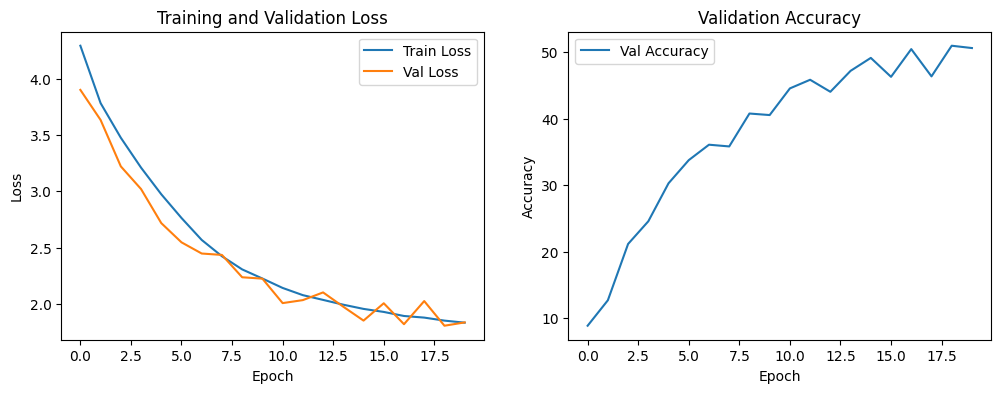

Total Trainable Parameters: 17121444


In [6]:
# ResNet 11 Cifar 100 Dropout = 0.5
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define ResNet-11 BasicBlock with Dropout
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=dropout)  # Added Dropout Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout after first ReLU
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet-11 model with Dropout
class ResNet11(nn.Module):
    def __init__(self, num_classes=100, dropout=0.5):
        super(ResNet11, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 11-layer ResNet Configuration
        self.layer1 = self._make_layer(64, 2, stride=1, dropout=dropout)  
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)  
        self.layer3 = self._make_layer(256, 3, stride=2, dropout=dropout)  
        self.layer4 = self._make_layer(512, 3, stride=2, dropout=dropout)  
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)  # Dropout before FC layer
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride, dropout):
        layers = [BasicBlock(self.in_channels, out_channels, stride, dropout)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout before classification
        x = self.fc(x)
        return x

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 mean and std
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet11(num_classes=100, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 4.1690, Val Loss: 3.7768, Val Acc: 10.43%
Epoch 2/20, Train Loss: 3.7067, Val Loss: 3.4281, Val Acc: 16.92%
Epoch 3/20, Train Loss: 3.3943, Val Loss: 3.2472, Val Acc: 20.20%
Epoch 4/20, Train Loss: 3.1116, Val Loss: 3.3202, Val Acc: 21.46%
Epoch 5/20, Train Loss: 2.8493, Val Loss: 2.6087, Val Acc: 32.14%
Epoch 6/20, Train Loss: 2.6135, Val Loss: 2.3404, Val Acc: 37.81%
Epoch 7/20, Train Loss: 2.4318, Val Loss: 2.2824, Val Acc: 38.92%
Epoch 8/20, Train Loss: 2.3076, Val Loss: 2.2541, Val Acc: 40.09%
Epoch 9/20, Train Loss: 2.2140, Val Loss: 2.1969, Val Acc: 42.71%
Epoch 10/20, Train Loss: 2.1385, Val Loss: 2.1452, Val Acc: 42.42%
Epoch 11/20, Train Loss: 2.0833, Val Loss: 2.2233, Val Acc: 42.37%
Epoch 12/20, Train Loss: 2.0334, Val Loss: 1.9667, Val Acc: 46.89%
Epoch 13/20, Train Loss: 1.9972, Val Loss: 2.1196, Val Acc: 43.64%
Epoch 14/20, Train Loss: 1.9623, Val Loss: 2.0383, Val Acc: 44

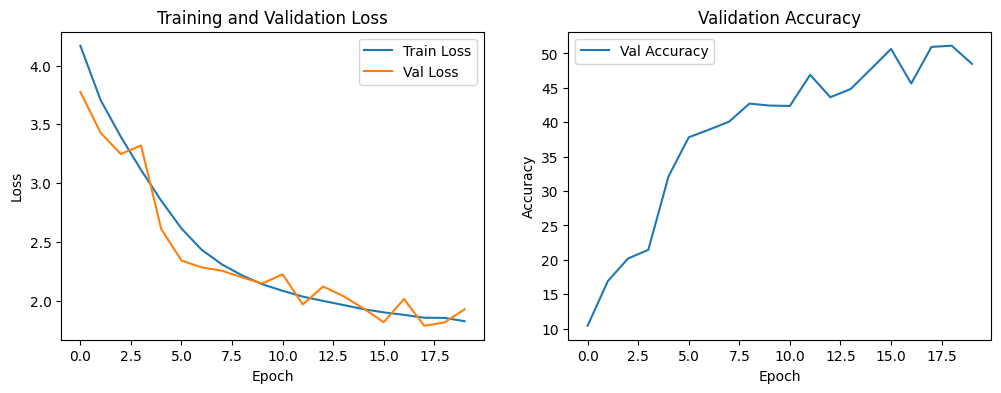

Total Trainable Parameters: 11220132


In [8]:
#  ResNet-18 CIFAR-100 Dropout =0.5
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define ResNet-18 BasicBlock with Dropout
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=dropout)  # Dropout after first activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet-18 with Dropout
class ResNet18(nn.Module):
    def __init__(self, num_classes=100, dropout=0.5):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # 18-layer ResNet configuration
        self.layer1 = self._make_layer(64, 2, stride=1, dropout=dropout)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout=dropout)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)  # Dropout before FC layer
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride, dropout):
        layers = [BasicBlock(self.in_channels, out_channels, stride, dropout)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout before classification
        x = self.fc(x)
        return x

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 mean and std
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=100, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 2.4085, Val Loss: 1.8245, Val Acc: 31.27%
Epoch 2/20, Train Loss: 1.7331, Val Loss: 1.5064, Val Acc: 43.99%
Epoch 3/20, Train Loss: 1.5166, Val Loss: 1.5561, Val Acc: 44.27%
Epoch 4/20, Train Loss: 1.3423, Val Loss: 1.2093, Val Acc: 56.51%
Epoch 5/20, Train Loss: 1.1718, Val Loss: 1.2927, Val Acc: 57.05%
Epoch 6/20, Train Loss: 1.0611, Val Loss: 1.0847, Val Acc: 61.76%
Epoch 7/20, Train Loss: 0.9650, Val Loss: 1.1969, Val Acc: 58.03%
Epoch 8/20, Train Loss: 0.8850, Val Loss: 0.8963, Val Acc: 69.01%
Epoch 9/20, Train Loss: 0.8111, Val Loss: 0.7755, Val Acc: 73.39%
Epoch 10/20, Train Loss: 0.7629, Val Loss: 0.7715, Val Acc: 73.60%
Epoch 11/20, Train Loss: 0.7146, Val Loss: 0.8958, Val Acc: 70.27%
Epoch 12/20, Train Loss: 0.6895, Val Loss: 0.6800, Val Acc: 77.03%
Epoch 13/20, Train Loss: 0.6708, Val Loss: 0.6830, Val Acc: 76.86%
Epoch 14/20, Train Loss: 0.6549, Val Loss: 0.7087, Val Acc: 76

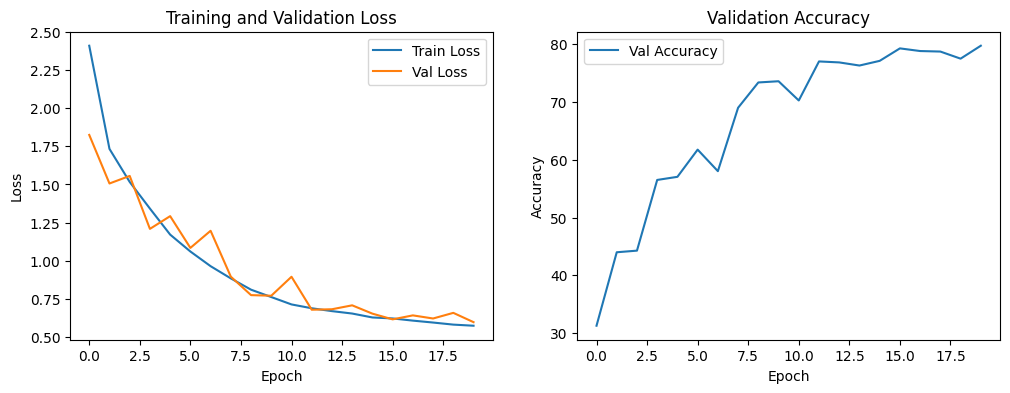

Total Trainable Parameters: 17075274


In [10]:
# resnet 11 cifar 10 dropout 0.5
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define ResNet-11 BasicBlock with Dropout
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=dropout)  # Dropout layer added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout after activation
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet-11 Model with Dropout
class ResNet11(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5):
        super(ResNet11, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 11-layer ResNet Configuration with Dropout
        self.layer1 = self._make_layer(64, 2, stride=1, dropout=dropout)  
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)  
        self.layer3 = self._make_layer(256, 3, stride=2, dropout=dropout)  
        self.layer4 = self._make_layer(512, 3, stride=2, dropout=dropout)  
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)  # Dropout before FC layer
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride, dropout):
        layers = [BasicBlock(self.in_channels, out_channels, stride, dropout)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout before classification
        x = self.fc(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet11(num_classes=10, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 2.1488, Val Loss: 1.8251, Val Acc: 31.83%
Epoch 2/20, Train Loss: 1.6129, Val Loss: 1.4957, Val Acc: 44.95%
Epoch 3/20, Train Loss: 1.3647, Val Loss: 1.2127, Val Acc: 56.07%
Epoch 4/20, Train Loss: 1.1668, Val Loss: 1.2704, Val Acc: 55.14%
Epoch 5/20, Train Loss: 1.0410, Val Loss: 0.9989, Val Acc: 63.97%
Epoch 6/20, Train Loss: 0.9443, Val Loss: 1.0208, Val Acc: 64.08%
Epoch 7/20, Train Loss: 0.8681, Val Loss: 0.9124, Val Acc: 68.14%
Epoch 8/20, Train Loss: 0.7889, Val Loss: 0.7934, Val Acc: 72.30%
Epoch 9/20, Train Loss: 0.7401, Val Loss: 0.8600, Val Acc: 70.94%
Epoch 10/20, Train Loss: 0.7020, Val Loss: 0.8668, Val Acc: 72.31%
Epoch 11/20, Train Loss: 0.6766, Val Loss: 0.7549, Val Acc: 73.92%
Epoch 12/20, Train Loss: 0.6614, Val Loss: 0.8466, Val Acc: 70.98%
Epoch 13/20, Train Loss: 0.6340, Val Loss: 0.6218, Val Acc: 79.04%
Epoch 14/20, Train Loss: 0.6284, Val Loss: 0.7669, Val Acc: 75

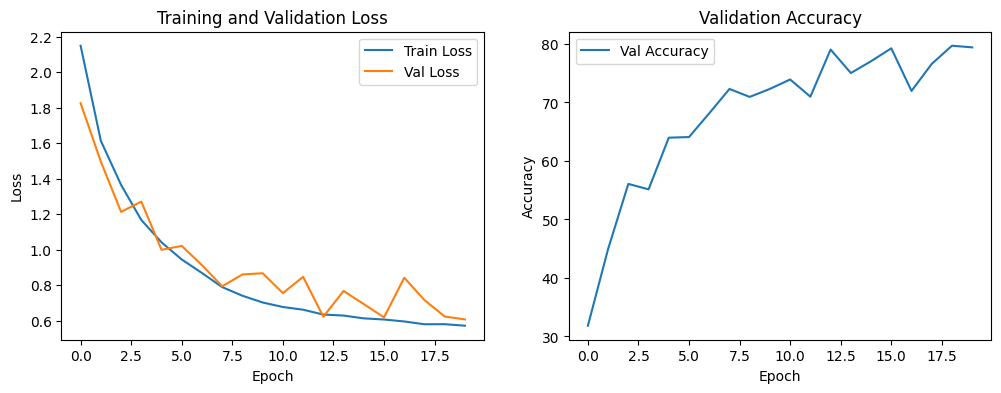

Total Trainable Parameters: 11173962


In [11]:
#resnet 18 cifar 10 dropout 0.5
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define ResNet-18 BasicBlock with Dropout
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=dropout)  # Dropout layer added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout after activation
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResNet-18 Model with Dropout
class ResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 18-layer ResNet Configuration with Dropout
        self.layer1 = self._make_layer(64, 2, stride=1, dropout=dropout)  
        self.layer2 = self._make_layer(128, 2, stride=2, dropout=dropout)  
        self.layer3 = self._make_layer(256, 2, stride=2, dropout=dropout)  
        self.layer4 = self._make_layer(512, 2, stride=2, dropout=dropout)  
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)  # Dropout before FC layer
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride, dropout):
        layers = [BasicBlock(self.in_channels, out_channels, stride, dropout)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout=dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout before classification
        x = self.fc(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=10, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")
